In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from models import basemodel, non_norm, ResnetLayer, Resnet, Resnet_regression, basemodel_regression, build_resnet, Resnet_pool, Resnet2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import pickle as pkl
import json
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from MobiusAPI.http_post_get import mobius_post, mobius_get
from acconeer.exptool import a121
import h5py

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.set_visible_devices(gpus[3], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

2023-10-20 12:19:33.534623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 12:19:33.646034: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 12:19:33.680790: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-20 12:19:34.261133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
def subplot(data_dict):
    # 서브플롯 그리기
    num_profiles = 0
    maximum = 0
    for i in data_dict:
        num_profiles += len(data_dict[i])
        maximum = np.max((len(data_dict[i]), maximum))
    # num_profiles = len(data_dict)
    print(num_profiles)
    plt.figure(figsize=(maximum * 5, num_profiles))

    for col, (key,profile) in enumerate(data_dict.items(), 1):
        for idx, (key2, profile2) in enumerate(profile.items(), 1):
            plt_idx = col + len(data_dict) * (idx - 1)
            # if col == 1:
            #     plt_idx = 2 * idx - 1
            # else:
            #     plt_idx = 2 * idx
            r, c, p = int(maximum), len(data_dict), plt_idx
            plt.subplot(r, c, p)
            plt.imshow(profile2, aspect='auto', cmap='jet', interpolation='none')
            # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
            plt.colorbar(label="dB")
            plt.xlabel("Range Bin")
            plt.ylabel("Pulse Number")
            plt.title(f"Range Profiles: {key}, {key2}")

    plt.tight_layout()
    plt.show()

In [3]:
def heatmap(matrix, title, label):
    save_path = 'plot/cm.png'
    df=pd.DataFrame(matrix, index = label, columns = label)
    plt.figure(figsize=(10,10))
    sns.heatmap(df, annot=True, fmt = 'd')
    plt.tick_params(axis='x', top=True, labeltop = True,bottom=False, labelbottom=False)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xlabel("Prediction",position = (0.5,1.0+0.05))
    plt.ylabel("Ground Truth")
    plt.title(title)
    plt.savefig(save_path, format='png', dpi=300)

In [26]:
def train_2D(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], X.shape[2], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [
                    callback, 
                    # early_stopping
                    ]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    Y_pred_label = y_pred
    Y_gt_label = y_gt
    cm = confusion_matrix(Y_gt_label, Y_pred_label)
    label = [str(i) for i in range(test_Y.shape[1])]
    heatmap(cm, 'Counting', label)
    return history

def train_regression(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [callback, early_stopping]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')


    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

# def heatmap(matrix, title, label):
#     save_path = 'plot/cm.png'
#     df=pd.DataFrame(matrix, index = label, columns = label)
#     plt.figure(figsize=(10,10))
#     sns.heatmap(df, annot=True, fmt = 'd')
#     plt.tick_params(axis='x', top=True, labeltop = True,bottom=False, labelbottom=False)
#     plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
#     plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
#     plt.xlabel("Prediction",position = (0.5,1.0+0.05))
#     plt.ylabel("Ground Truth")
#     plt.title(title)
#     plt.savefig('cm.png', format='png', dpi=300)

In [5]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [6]:
def file_sort(path):
    file_list = os.listdir(path)
    for file in file_list:
        if os.path.isfile(os.path.join(path, file)):
            tmp = file.split('_')
            tmp[0] = tmp[0].zfill(2)
            createFolder('./'+path+'/' + tmp[0])
            shutil.move('./'+path+'/' + file, './'+path+'/' + tmp[0] + '/' + file)

In [7]:
def file_load(path):
    # data = list()
    file_list = os.listdir(path)
    data = None
    for file in file_list:
        file_path = os.path.join(path,file)
        if os.path.isfile(file_path):
            # print(file_path)
            try:
                temp = np.load(file_path)

                if data is not None:
                    data = np.concatenate((data, temp), axis = 0)
                else:
                    data = temp
            except:
                print('error', file_path)
            # data.append(temp)
    return np.squeeze(data, axis = 1)

def file_load2(path):
    # data = list()
    file_list = os.listdir(path)
    data = None
    data_dict = dict()
    for file in file_list:
        file_path = os.path.join(path,file)
        temp_key = file.split('_')[1]
        if os.path.isfile(file_path):
            # print(file_path)
            try:
                with h5py.File(file_path, 'r') as f:
                    # 데이터셋 로드
                    data = list(f['session']['group_0']['entry_0']['result']['frame'])
                    data = np.array(data)
                    complex_arr = data['real'] + 1j * data['imag']
                    amp_data = np.abs(complex_arr)
                    phs_data = np.angle(complex_arr)
                    temp_data = np.array([amp_data, phs_data])
                if temp_key not in data_dict.keys():
                    data_dict[temp_key] = temp_data
                else:
                    data_dict[temp_key] = np.concatenate((data_dict[temp_key], temp_data), axis = 0)
            except:
                print('error', file_path)
            # data.append(temp)
    sorted_data = dict(sorted(data_dict.items(), key=lambda x: x[0]))
    return sorted_data

In [8]:
def file_load_split(folder_path, folder_list, minmax, initial_data = None):
    train_dict = dict()
    test_dict = dict()
    for folder in folder_list:
        temp_path = os.path.join(folder_path,folder)
        file_list = os.listdir(temp_path)
        for file in file_list:
            temp_file = file.split('_')
            file_path = os.path.join(temp_path, file)
            if os.path.isfile(file_path):
                # print(file_path)
                temp = np.squeeze(np.load(file_path), axis = 1)
                temp = np.expand_dims(temp, axis = 2)
                # temp = minmax.transform(np.squeeze(np.load(file_path), axis = 1))
                if initial_data is not None:
                    temp = np.subtract(temp, initial_data)
                temp = minmax.transform(temp)
                if temp_file[1] == '5' or temp_file[1] == '4':
                    test_dict = make_arr(test_dict, folder, temp)
                else:
                    train_dict = make_arr(train_dict, folder, temp)
    return train_dict, test_dict

def make_arr(dict, key, data):
    if key in dict.keys():
        dict[key] = np.concatenate((dict[key], data), axis = 0)
    else:
        dict[key] = data
    return dict

In [9]:
# folder_path = 'counting_cylinder_demo'
folder_path = 'counting_disk_h5'
# folder_path = 'counting'
# folder_path = 'countingdatasmall'

In [10]:
file_sort(folder_path)

In [11]:
folder_list = os.listdir(folder_path)

In [12]:
folder_list = sorted(folder_list)

In [13]:
data_dict = dict()
for folder in folder_list:
    temp_path = os.path.join(folder_path,folder)
    data_dict[folder] = file_load2(temp_path)

In [14]:
data_dict['00']['0'].shape

(2, 60, 10, 170)

In [15]:
var_dict = dict()
for i in data_dict:
    var_dict[i] = dict()
    for j in data_dict[i]:
        amp = np.mean(data_dict[i][j][0], axis = 1)
        phs = np.var(data_dict[i][j][1], axis = 1)
        var_dict[i][j] = np.array([amp, phs])

In [16]:
var_dict['00']['0'].shape

(2, 60, 170)

In [17]:
amp = dict()
for i in var_dict:
    amp[i] = dict()
    for j in var_dict[i]:
        amp[i][j] = var_dict[i][j][0]
phs = dict()
for i in var_dict:
    phs[i] = dict()
    for j in var_dict[i]:
        phs[i][j] = var_dict[i][j][1]

In [18]:
dataset = dict()
for i in var_dict:
    dataset[i] = dict()
    for j in var_dict[i]:
        dataset[i][j] = np.expand_dims(np.moveaxis(var_dict[i][j], 0, -2), axis=-1)

12


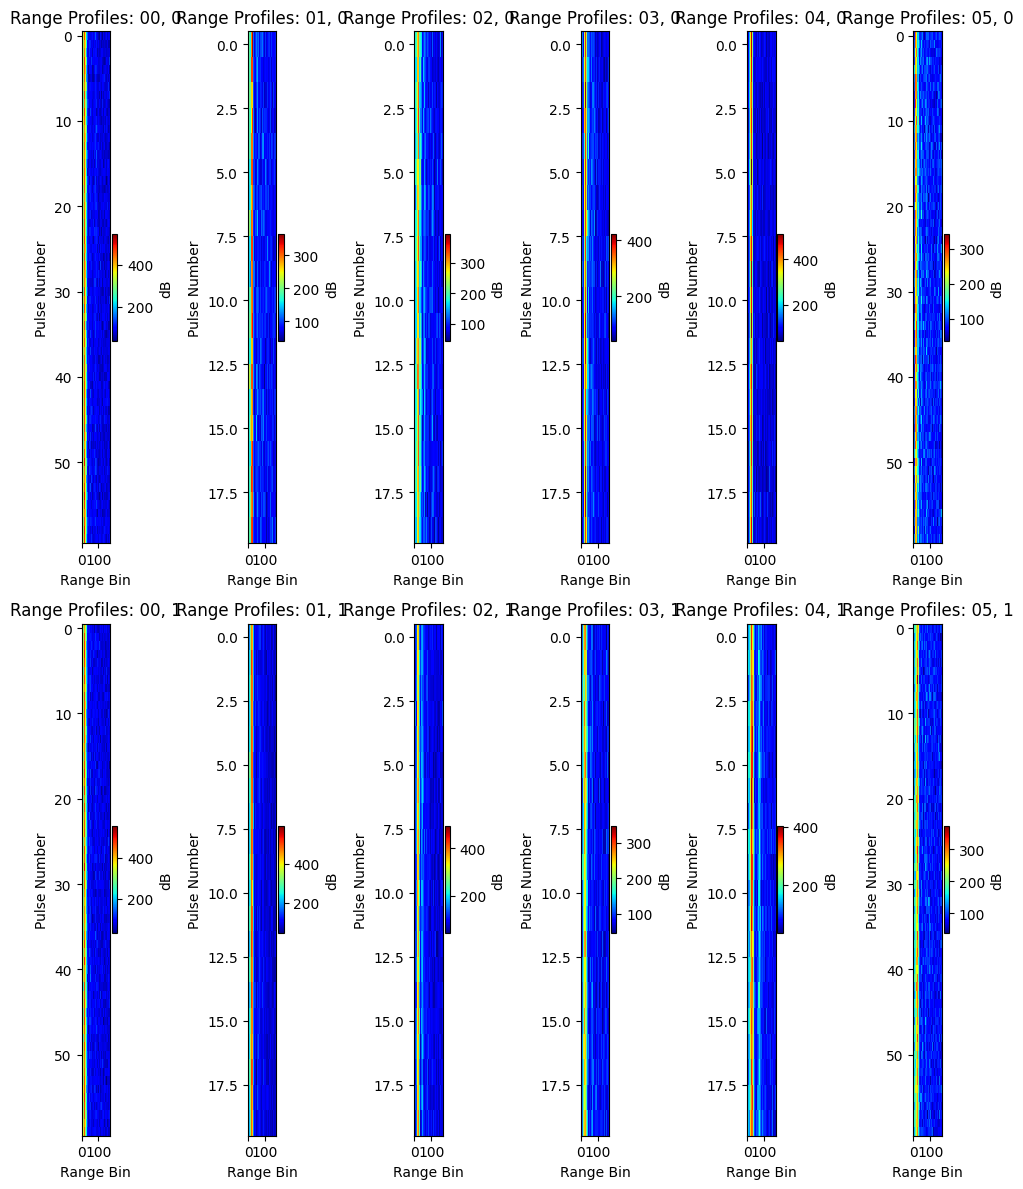

In [19]:
subplot(amp)

12


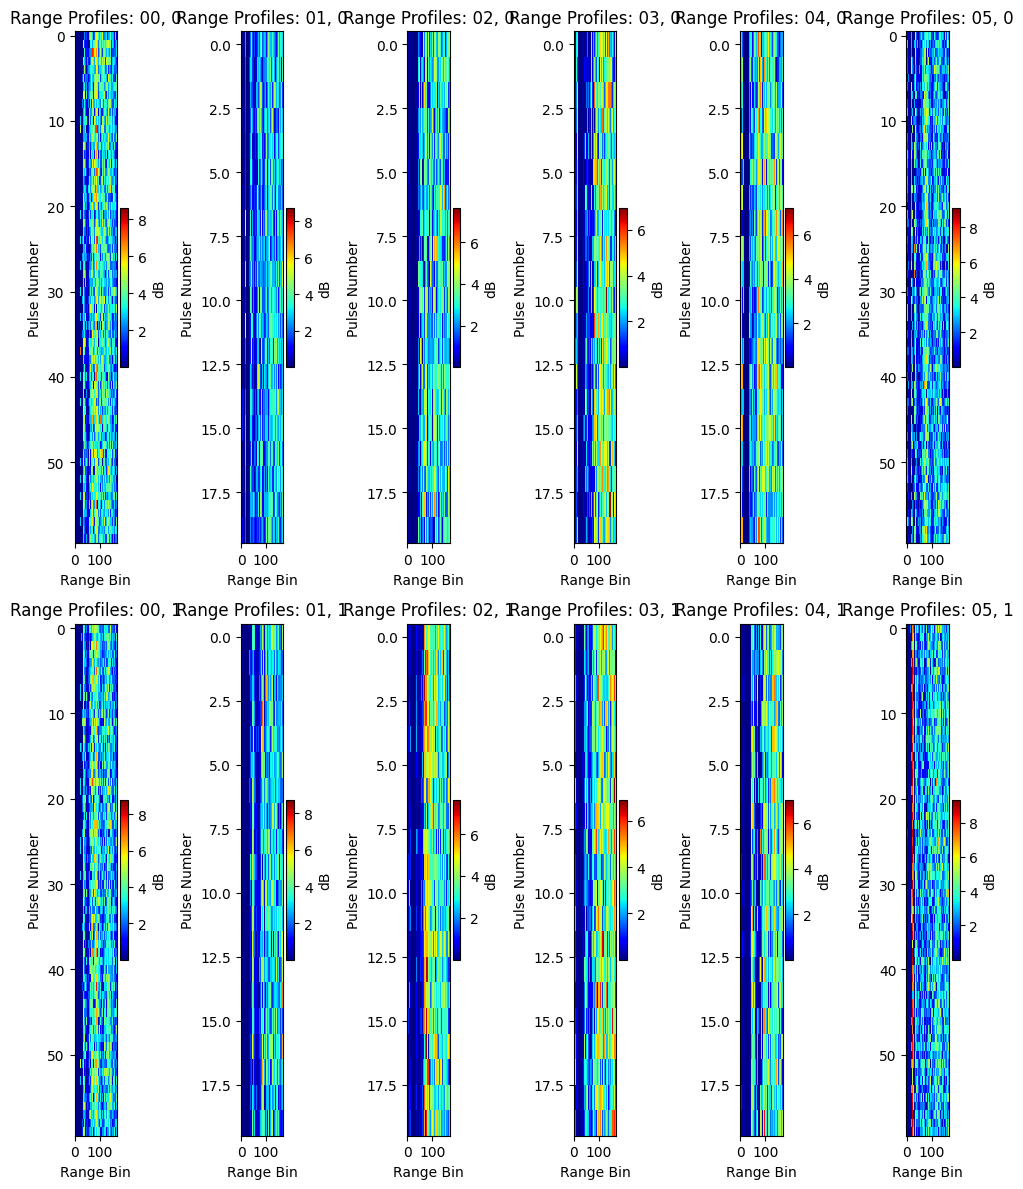

In [20]:
subplot(phs)

In [21]:
def train_test_dict(data):
    train_dict, test_dict = dict(), dict()
    for i in data.keys():
        train_dict[i], test_dict[i] = dict(), dict()
        for j in data[i].keys():
            if j == '0' or j == '4':
                test_dict[i][j] = data[i][j]
            else:
                train_dict[i][j] = data[i][j]
    return train_dict, test_dict

In [22]:
from sklearn.utils import shuffle

def make_dataset_split(train_dict, test_dict):
    # x = list()    
    def make_label(data_dict):
        Y = list()
        X = list()
        for key, data in data_dict.items():
            # print(key)
            if key == 'initial':
                continue
            else:
                x = None
                y = list()
                for key2, data2 in data_dict[key].items():
                    if x is None:
                        x = data2
                    else:
                        x = np.concatenate((x, data2), axis = 0)
                for i in range(x.shape[0]):
                    one_hot = to_categorical(int(key), num_classes=(len(data_dict)-1))
                    y.append(one_hot)
                    
                X.append(x)
                Y.append(y)

        np_X = X[0]
        for i in range(1, len(X)):
            np_X = np.concatenate((np_X, X[i]), axis = 0)
        np_Y = Y[0]
        for i in range(1, len(Y)):
            np_Y = np.concatenate((np_Y, Y[i]), axis = 0)
        
        X, Y = np.array(np_X), np.array(np_Y)
        print('X_shape : ' , X.shape)
        print('Y_shape : ' , Y.shape)

        # X = np.reshape(X, (X.shape[0]*X.shape[1], X.shape[2], X.shape[3]))
        # Y = np.reshape(Y, (Y.shape[0]*Y.shape[1], Y.shape[2]))
        return X, Y
    
    X_train, Y_train = make_label(train_dict)
    X_test, Y_test = make_label(test_dict)
    X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
    X_test, Y_test = shuffle(X_test, Y_test, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [23]:
def make_dataset(data_dict, test_size = 0.2):
    # x = list()
    Y = list()
    X = list()
    for key, data in data_dict.items():
        if key == 'initial':
            continue
        else:
            x = None
            y = list()
            for key2, data2 in data_dict[key].items():
                if x is None:
                    x = data2
                else:
                    x = np.concatenate((x, data2), axis = 0)
            for i in range(x.shape[0]):
                one_hot = to_categorical(int(key), num_classes=(len(data_dict)))
                y.append(one_hot)
            X.append(x)
            Y.append(y)
    np_X = X[0]
    for i in range(1, len(X)):
        np_X = np.concatenate((np_X, X[i]), axis = 0)
    np_Y = Y[0]
    for i in range(1, len(Y)):
        np_Y = np.concatenate((np_Y, Y[i]), axis = 0)
        
    X, Y = np.array(np_X), np.array(np_Y)
    # X = np.reshape(X, (X.shape[0]*X.shape[1], X.shape[2], X.shape[3]))
    # Y = np.reshape(Y, (Y.shape[0]*Y.shape[1], Y.shape[2]))
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [24]:
# X_train, X_test, Y_train, Y_test = make_dataset(range_fft_dict)
# X_train, X_test  = 10 * np.log10(X_train), 10 * np.log10(X_test)
# X_train, X_test, Y_train, Y_test = make_dataset(normalized_data)
X_train, X_test, Y_train, Y_test = make_dataset(dataset)
# X_train, X_test = np.expand_dims(X_train, axis = 2), np.expand_dims(X_test, axis = 2)

X shape :  (320, 2, 170, 1)
Model: "resnet2d_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet_layer2d_2 (ResnetLay  multiple                 108484    
 er2D)                                                           
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  2785408   
                                                                 
 dense_9 (Dense)             multiple                  8256      
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  2080      
                            

2023-10-20 12:20:59.047410: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-20 12:20:59.415026: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


 7/10 [====================>.........] - ETA: 0s - loss: 78.0661 - accuracy: 0.2366 - categorical_crossentropy: 78.0661 

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 12s 545ms/step - loss: 65.3539 - accuracy: 0.2594 - categorical_crossentropy: 65.3539 - val_loss: 30.8601 - val_accuracy: 0.0625 - val_categorical_crossentropy: 30.8601
Epoch 2/200
 8/10 [=======================>......] - ETA: 0s - loss: 16.6868 - accuracy: 0.1562 - categorical_crossentropy: 16.6868

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 467ms/step - loss: 14.4811 - accuracy: 0.1937 - categorical_crossentropy: 14.4811 - val_loss: 4.4406 - val_accuracy: 0.3875 - val_categorical_crossentropy: 4.4406
Epoch 3/200
10/10 [==============================] - 0s 25ms/step - loss: 4.1142 - accuracy: 0.3500 - categorical_crossentropy: 4.1142 - val_loss: 2.3694 - val_accuracy: 0.3875 - val_categorical_crossentropy: 2.3694
Epoch 4/200
10/10 [==============================] - 0s 25ms/step - loss: 1.7681 - accuracy: 0.5406 - categorical_crossentropy: 1.7681 - val_loss: 1.9526 - val_accuracy: 0.1000 - val_categorical_crossentropy: 1.9526
Epoch 5/200
10/10 [==============================] - 0s 25ms/step - loss: 1.1613 - accuracy: 0.6219 - categorical_crossentropy: 1.1613 - val_loss: 2.0287 - val_accuracy: 0.0875 - val_categorical_crossentropy: 2.0287
Epoch 6/200
10/10 [==============================] - 0s 23ms/step - loss: 0.9300 - accuracy: 0.6969 - categorical_crossentropy: 0.9300 - val_loss

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 437ms/step - loss: 0.5172 - accuracy: 0.8219 - categorical_crossentropy: 0.5172 - val_loss: 1.9710 - val_accuracy: 0.4875 - val_categorical_crossentropy: 1.9710
Epoch 10/200
10/10 [==============================] - 0s 24ms/step - loss: 0.4418 - accuracy: 0.8313 - categorical_crossentropy: 0.4418 - val_loss: 1.5668 - val_accuracy: 0.4875 - val_categorical_crossentropy: 1.5668
Epoch 11/200
 7/10 [====================>.........] - ETA: 0s - loss: 0.3568 - accuracy: 0.8884 - categorical_crossentropy: 0.3568

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 478ms/step - loss: 0.3584 - accuracy: 0.8969 - categorical_crossentropy: 0.3584 - val_loss: 1.4215 - val_accuracy: 0.5750 - val_categorical_crossentropy: 1.4215
Epoch 12/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.3232 - accuracy: 0.8854 - categorical_crossentropy: 0.3232

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 474ms/step - loss: 0.3220 - accuracy: 0.8875 - categorical_crossentropy: 0.3220 - val_loss: 1.4043 - val_accuracy: 0.6000 - val_categorical_crossentropy: 1.4043
Epoch 13/200
 8/10 [=======================>......] - ETA: 0s - loss: 0.2679 - accuracy: 0.9375 - categorical_crossentropy: 0.2679

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 473ms/step - loss: 0.2695 - accuracy: 0.9250 - categorical_crossentropy: 0.2695 - val_loss: 1.4047 - val_accuracy: 0.6250 - val_categorical_crossentropy: 1.4047
Epoch 14/200
10/10 [==============================] - 0s 22ms/step - loss: 0.1996 - accuracy: 0.9250 - categorical_crossentropy: 0.1996 - val_loss: 1.5405 - val_accuracy: 0.6125 - val_categorical_crossentropy: 1.5405
Epoch 15/200
 8/10 [=======================>......] - ETA: 0s - loss: 0.1531 - accuracy: 0.9453 - categorical_crossentropy: 0.1531

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 471ms/step - loss: 0.1700 - accuracy: 0.9312 - categorical_crossentropy: 0.1700 - val_loss: 1.2295 - val_accuracy: 0.6625 - val_categorical_crossentropy: 1.2295
Epoch 16/200
10/10 [==============================] - 0s 23ms/step - loss: 0.1623 - accuracy: 0.9344 - categorical_crossentropy: 0.1623 - val_loss: 1.7056 - val_accuracy: 0.5625 - val_categorical_crossentropy: 1.7056
Epoch 17/200
10/10 [==============================] - 0s 24ms/step - loss: 0.1634 - accuracy: 0.9312 - categorical_crossentropy: 0.1634 - val_loss: 1.4602 - val_accuracy: 0.6500 - val_categorical_crossentropy: 1.4602
Epoch 18/200
10/10 [==============================] - 0s 25ms/step - loss: 0.2228 - accuracy: 0.9281 - categorical_crossentropy: 0.2228 - val_loss: 1.2774 - val_accuracy: 0.6375 - val_categorical_crossentropy: 1.2774
Epoch 19/200
10/10 [==============================] - 0s 24ms/step - loss: 0.1342 - accuracy: 0.9469 - categorical_crossentropy: 0.1342 - val_lo

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 492ms/step - loss: 0.0850 - accuracy: 0.9812 - categorical_crossentropy: 0.0850 - val_loss: 1.0708 - val_accuracy: 0.7125 - val_categorical_crossentropy: 1.0708
Epoch 21/200
 8/10 [=======================>......] - ETA: 0s - loss: 0.0920 - accuracy: 0.9727 - categorical_crossentropy: 0.0920

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 427ms/step - loss: 0.0829 - accuracy: 0.9750 - categorical_crossentropy: 0.0829 - val_loss: 0.9614 - val_accuracy: 0.7375 - val_categorical_crossentropy: 0.9614
Epoch 22/200
 8/10 [=======================>......] - ETA: 0s - loss: 0.0873 - accuracy: 0.9805 - categorical_crossentropy: 0.0873

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 489ms/step - loss: 0.0855 - accuracy: 0.9844 - categorical_crossentropy: 0.0855 - val_loss: 0.8246 - val_accuracy: 0.7625 - val_categorical_crossentropy: 0.8246
Epoch 23/200
10/10 [==============================] - 0s 22ms/step - loss: 0.1021 - accuracy: 0.9719 - categorical_crossentropy: 0.1021 - val_loss: 0.9313 - val_accuracy: 0.6875 - val_categorical_crossentropy: 0.9313
Epoch 24/200
10/10 [==============================] - 0s 24ms/step - loss: 0.0613 - accuracy: 0.9844 - categorical_crossentropy: 0.0613 - val_loss: 0.7068 - val_accuracy: 0.7375 - val_categorical_crossentropy: 0.7068
Epoch 25/200
10/10 [==============================] - 0s 26ms/step - loss: 0.0927 - accuracy: 0.9688 - categorical_crossentropy: 0.0927 - val_loss: 0.8150 - val_accuracy: 0.7500 - val_categorical_crossentropy: 0.8150
Epoch 26/200
10/10 [==============================] - 0s 24ms/step - loss: 0.0861 - accuracy: 0.9844 - categorical_crossentropy: 0.0861 - val_lo

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 484ms/step - loss: 0.0653 - accuracy: 0.9844 - categorical_crossentropy: 0.0653 - val_loss: 0.4943 - val_accuracy: 0.8000 - val_categorical_crossentropy: 0.4943
Epoch 28/200
10/10 [==============================] - 0s 24ms/step - loss: 0.0859 - accuracy: 0.9750 - categorical_crossentropy: 0.0859 - val_loss: 0.6753 - val_accuracy: 0.7625 - val_categorical_crossentropy: 0.6753
Epoch 29/200
10/10 [==============================] - 0s 28ms/step - loss: 0.0555 - accuracy: 0.9844 - categorical_crossentropy: 0.0555 - val_loss: 0.5307 - val_accuracy: 0.7750 - val_categorical_crossentropy: 0.5307
Epoch 30/200
 8/10 [=======================>......] - ETA: 0s - loss: 0.0681 - accuracy: 0.9727 - categorical_crossentropy: 0.0681

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 5s 510ms/step - loss: 0.0593 - accuracy: 0.9781 - categorical_crossentropy: 0.0593 - val_loss: 0.2815 - val_accuracy: 0.8875 - val_categorical_crossentropy: 0.2815
Epoch 31/200
10/10 [==============================] - 0s 23ms/step - loss: 0.0558 - accuracy: 0.9844 - categorical_crossentropy: 0.0558 - val_loss: 0.3442 - val_accuracy: 0.8625 - val_categorical_crossentropy: 0.3442
Epoch 32/200
10/10 [==============================] - 0s 25ms/step - loss: 0.0886 - accuracy: 0.9688 - categorical_crossentropy: 0.0886 - val_loss: 0.6571 - val_accuracy: 0.7750 - val_categorical_crossentropy: 0.6571
Epoch 33/200
10/10 [==============================] - 0s 25ms/step - loss: 0.0661 - accuracy: 0.9844 - categorical_crossentropy: 0.0661 - val_loss: 0.3472 - val_accuracy: 0.8500 - val_categorical_crossentropy: 0.3472
Epoch 34/200
10/10 [==============================] - 0s 26ms/step - loss: 0.0316 - accuracy: 0.9937 - categorical_crossentropy: 0.0316 - val_lo

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 5s 553ms/step - loss: 0.0351 - accuracy: 0.9937 - categorical_crossentropy: 0.0351 - val_loss: 0.0876 - val_accuracy: 0.9500 - val_categorical_crossentropy: 0.0876
Epoch 36/200
10/10 [==============================] - 0s 26ms/step - loss: 0.0267 - accuracy: 0.9875 - categorical_crossentropy: 0.0267 - val_loss: 0.3482 - val_accuracy: 0.8375 - val_categorical_crossentropy: 0.3482
Epoch 37/200
10/10 [==============================] - 0s 24ms/step - loss: 0.0611 - accuracy: 0.9781 - categorical_crossentropy: 0.0611 - val_loss: 0.3287 - val_accuracy: 0.8250 - val_categorical_crossentropy: 0.3287
Epoch 38/200
10/10 [==============================] - 0s 25ms/step - loss: 0.0245 - accuracy: 0.9937 - categorical_crossentropy: 0.0245 - val_loss: 0.3468 - val_accuracy: 0.8250 - val_categorical_crossentropy: 0.3468
Epoch 39/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.0145 - accuracy: 0.9965 - categorical_crossentropy: 0.0145

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 4s 495ms/step - loss: 0.0154 - accuracy: 0.9969 - categorical_crossentropy: 0.0154 - val_loss: 0.0374 - val_accuracy: 0.9875 - val_categorical_crossentropy: 0.0374
Epoch 40/200
10/10 [==============================] - 0s 24ms/step - loss: 0.0164 - accuracy: 0.9937 - categorical_crossentropy: 0.0164 - val_loss: 0.0271 - val_accuracy: 0.9875 - val_categorical_crossentropy: 0.0271
Epoch 41/200
10/10 [==============================] - 0s 24ms/step - loss: 0.0213 - accuracy: 0.9875 - categorical_crossentropy: 0.0213 - val_loss: 0.1120 - val_accuracy: 0.9625 - val_categorical_crossentropy: 0.1120
Epoch 42/200
10/10 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 1.0000 - categorical_crossentropy: 0.0120

INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_disk/assets


10/10 [==============================] - 5s 503ms/step - loss: 0.0120 - accuracy: 1.0000 - categorical_crossentropy: 0.0120 - val_loss: 0.0063 - val_accuracy: 1.0000 - val_categorical_crossentropy: 0.0063
Epoch 43/200
10/10 [==============================] - 0s 27ms/step - loss: 0.0212 - accuracy: 0.9937 - categorical_crossentropy: 0.0212 - val_loss: 0.0309 - val_accuracy: 0.9875 - val_categorical_crossentropy: 0.0309
Epoch 44/200
10/10 [==============================] - 0s 24ms/step - loss: 0.0109 - accuracy: 0.9969 - categorical_crossentropy: 0.0109 - val_loss: 0.0030 - val_accuracy: 1.0000 - val_categorical_crossentropy: 0.0030
Epoch 45/200
10/10 [==============================] - 0s 25ms/step - loss: 0.0105 - accuracy: 0.9937 - categorical_crossentropy: 0.0105 - val_loss: 0.0037 - val_accuracy: 1.0000 - val_categorical_crossentropy: 0.0037
Epoch 46/200
10/10 [==============================] - 0s 25ms/step - loss: 0.0179 - accuracy: 0.9906 - categorical_crossentropy: 0.0179 - val_lo

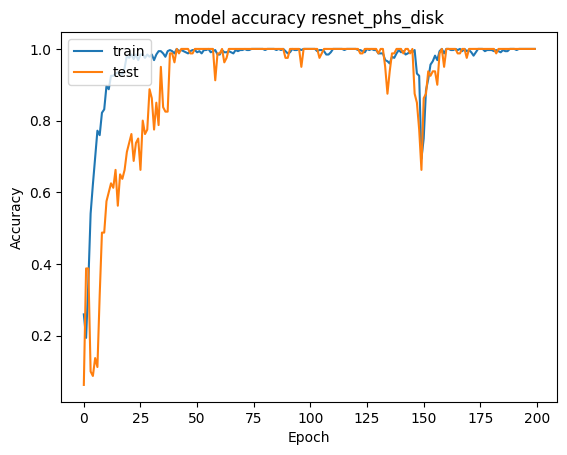

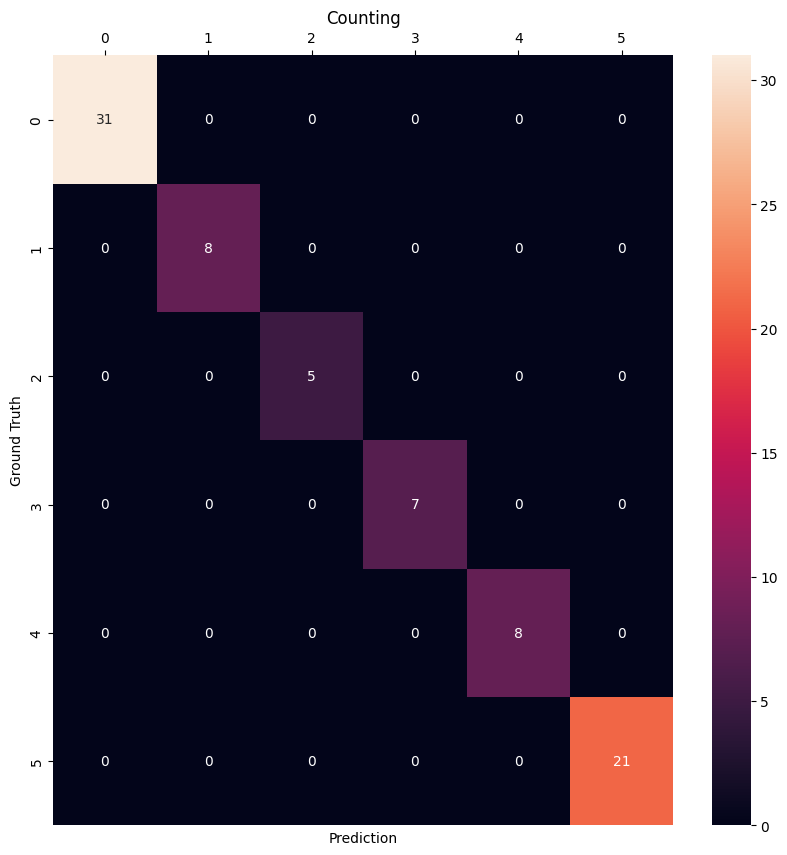

In [28]:
# non_norm_model = non_norm(len(range_fft_dict))
# base model
# model = basemodel(len(range_fft_dict))

# Resnet
filter_in_list = 2
filter_out_list = [32, 32, 64, 64]
kernel_size = (2,3)
# model = build_resnet(filter_in_list = filter_in_list, filter_out_list = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
model = Resnet2D(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=Y_train.shape[1])
# model = Resnet(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=Y_train.shape[1])
history = train_2D(model = model, X = X_train, Y = Y_train, test_X = X_test, test_Y = Y_test, cp_path = 'resnet_phs_disk', Epoch=200)

X shape :  (320, 2, 170, 1)
Model: "resnet2d_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet_layer2d_3 (ResnetLay  multiple                 56164     
 er2D)                                                           
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  2785408   
                                                                 
 dense_13 (Dense)            multiple                  8256      
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_14 (Dense)            multiple                  2080      
                            

INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


10/10 [==============================] - 6s 559ms/step - loss: 184.7390 - accuracy: 0.2281 - categorical_crossentropy: 184.7390 - val_loss: 300.4269 - val_accuracy: 0.2625 - val_categorical_crossentropy: 300.4269
Epoch 2/200
10/10 [==============================] - 0s 23ms/step - loss: 103.0424 - accuracy: 0.2969 - categorical_crossentropy: 103.0424 - val_loss: 882.5059 - val_accuracy: 0.2625 - val_categorical_crossentropy: 882.5059
Epoch 3/200
10/10 [==============================] - 0s 23ms/step - loss: 20.1697 - accuracy: 0.3969 - categorical_crossentropy: 20.1697 - val_loss: 579.4266 - val_accuracy: 0.2625 - val_categorical_crossentropy: 579.4266
Epoch 4/200
10/10 [==============================] - 0s 22ms/step - loss: 23.4526 - accuracy: 0.2500 - categorical_crossentropy: 23.4526 - val_loss: 37.6997 - val_accuracy: 0.1625 - val_categorical_crossentropy: 37.6997
Epoch 5/200
10/10 [==============================] - 0s 23ms/step - loss: 11.6784 - accuracy: 0.3750 - categorical_crosse

INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


10/10 [==============================] - 5s 502ms/step - loss: 6.1808 - accuracy: 0.3125 - categorical_crossentropy: 6.1808 - val_loss: 5.4570 - val_accuracy: 0.6625 - val_categorical_crossentropy: 5.4570
Epoch 7/200
10/10 [==============================] - 0s 23ms/step - loss: 4.1717 - accuracy: 0.4187 - categorical_crossentropy: 4.1717 - val_loss: 6.7713 - val_accuracy: 0.0000e+00 - val_categorical_crossentropy: 6.7713
Epoch 8/200
10/10 [==============================] - 0s 24ms/step - loss: 1.6965 - accuracy: 0.5594 - categorical_crossentropy: 1.6965 - val_loss: 1.7956 - val_accuracy: 0.5750 - val_categorical_crossentropy: 1.7956
Epoch 9/200
10/10 [==============================] - 0s 24ms/step - loss: 1.2505 - accuracy: 0.6250 - categorical_crossentropy: 1.2505 - val_loss: 6.6637 - val_accuracy: 0.1000 - val_categorical_crossentropy: 6.6637
Epoch 10/200
10/10 [==============================] - 0s 25ms/step - loss: 1.0942 - accuracy: 0.6406 - categorical_crossentropy: 1.0942 - val_l

INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


10/10 [==============================] - 4s 470ms/step - loss: 1.0627 - accuracy: 0.6531 - categorical_crossentropy: 1.0627 - val_loss: 0.7319 - val_accuracy: 0.6750 - val_categorical_crossentropy: 0.7319
Epoch 13/200
10/10 [==============================] - 0s 24ms/step - loss: 1.0134 - accuracy: 0.6594 - categorical_crossentropy: 1.0134 - val_loss: 0.7438 - val_accuracy: 0.6250 - val_categorical_crossentropy: 0.7438
Epoch 14/200
 8/10 [=======================>......] - ETA: 0s - loss: 0.7664 - accuracy: 0.7422 - categorical_crossentropy: 0.7664

INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


10/10 [==============================] - 4s 479ms/step - loss: 0.7798 - accuracy: 0.7312 - categorical_crossentropy: 0.7798 - val_loss: 0.7269 - val_accuracy: 0.6875 - val_categorical_crossentropy: 0.7269
Epoch 15/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.7505 - accuracy: 0.7118 - categorical_crossentropy: 0.7505

INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


10/10 [==============================] - 4s 435ms/step - loss: 0.7424 - accuracy: 0.7125 - categorical_crossentropy: 0.7424 - val_loss: 0.4701 - val_accuracy: 0.9250 - val_categorical_crossentropy: 0.4701
Epoch 16/200
10/10 [==============================] - 0s 22ms/step - loss: 0.6490 - accuracy: 0.8094 - categorical_crossentropy: 0.6490 - val_loss: 0.4471 - val_accuracy: 0.7375 - val_categorical_crossentropy: 0.4471
Epoch 17/200
10/10 [==============================] - 0s 23ms/step - loss: 0.8112 - accuracy: 0.7375 - categorical_crossentropy: 0.8112 - val_loss: 0.5271 - val_accuracy: 0.9125 - val_categorical_crossentropy: 0.5271
Epoch 18/200
10/10 [==============================] - 0s 24ms/step - loss: 0.5872 - accuracy: 0.8250 - categorical_crossentropy: 0.5872 - val_loss: 0.4064 - val_accuracy: 0.8125 - val_categorical_crossentropy: 0.4064
Epoch 19/200
10/10 [==============================] - 0s 23ms/step - loss: 0.5214 - accuracy: 0.8562 - categorical_crossentropy: 0.5214 - val_lo

INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


10/10 [==============================] - 4s 487ms/step - loss: 0.4503 - accuracy: 0.8594 - categorical_crossentropy: 0.4503 - val_loss: 0.2696 - val_accuracy: 0.9625 - val_categorical_crossentropy: 0.2696
Epoch 22/200
10/10 [==============================] - 0s 23ms/step - loss: 0.4445 - accuracy: 0.8875 - categorical_crossentropy: 0.4445 - val_loss: 0.2866 - val_accuracy: 0.9250 - val_categorical_crossentropy: 0.2866
Epoch 23/200
10/10 [==============================] - 0s 27ms/step - loss: 0.4564 - accuracy: 0.8469 - categorical_crossentropy: 0.4564 - val_loss: 0.2780 - val_accuracy: 0.9500 - val_categorical_crossentropy: 0.2780
Epoch 24/200
10/10 [==============================] - 0s 24ms/step - loss: 0.4464 - accuracy: 0.8687 - categorical_crossentropy: 0.4464 - val_loss: 0.2511 - val_accuracy: 0.9250 - val_categorical_crossentropy: 0.2511
Epoch 25/200
 8/10 [=======================>......] - ETA: 0s - loss: 0.3949 - accuracy: 0.8672 - categorical_crossentropy: 0.3949

INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


10/10 [==============================] - 4s 473ms/step - loss: 0.4254 - accuracy: 0.8562 - categorical_crossentropy: 0.4254 - val_loss: 0.2036 - val_accuracy: 0.9875 - val_categorical_crossentropy: 0.2036
Epoch 26/200
10/10 [==============================] - 0s 24ms/step - loss: 0.4258 - accuracy: 0.8656 - categorical_crossentropy: 0.4258 - val_loss: 0.2145 - val_accuracy: 0.9375 - val_categorical_crossentropy: 0.2145
Epoch 27/200
10/10 [==============================] - 0s 24ms/step - loss: 0.3909 - accuracy: 0.8750 - categorical_crossentropy: 0.3909 - val_loss: 0.1624 - val_accuracy: 0.9500 - val_categorical_crossentropy: 0.1624
Epoch 28/200
10/10 [==============================] - 0s 22ms/step - loss: 0.4660 - accuracy: 0.8719 - categorical_crossentropy: 0.4660 - val_loss: 0.1671 - val_accuracy: 0.9625 - val_categorical_crossentropy: 0.1671
Epoch 29/200
10/10 [==============================] - 0s 23ms/step - loss: 0.2953 - accuracy: 0.9062 - categorical_crossentropy: 0.2953 - val_lo

INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_phs_1_3_disk/assets


10/10 [==============================] - 4s 488ms/step - loss: 0.3721 - accuracy: 0.8750 - categorical_crossentropy: 0.3721 - val_loss: 0.1591 - val_accuracy: 1.0000 - val_categorical_crossentropy: 0.1591
Epoch 34/200
10/10 [==============================] - 0s 22ms/step - loss: 0.3013 - accuracy: 0.9062 - categorical_crossentropy: 0.3013 - val_loss: 0.1258 - val_accuracy: 1.0000 - val_categorical_crossentropy: 0.1258
Epoch 35/200
10/10 [==============================] - 0s 26ms/step - loss: 0.3803 - accuracy: 0.8813 - categorical_crossentropy: 0.3803 - val_loss: 0.1282 - val_accuracy: 1.0000 - val_categorical_crossentropy: 0.1282
Epoch 36/200
10/10 [==============================] - 0s 24ms/step - loss: 0.2905 - accuracy: 0.9062 - categorical_crossentropy: 0.2905 - val_loss: 0.1479 - val_accuracy: 0.9250 - val_categorical_crossentropy: 0.1479
Epoch 37/200
10/10 [==============================] - 0s 25ms/step - loss: 0.2804 - accuracy: 0.8969 - categorical_crossentropy: 0.2804 - val_lo

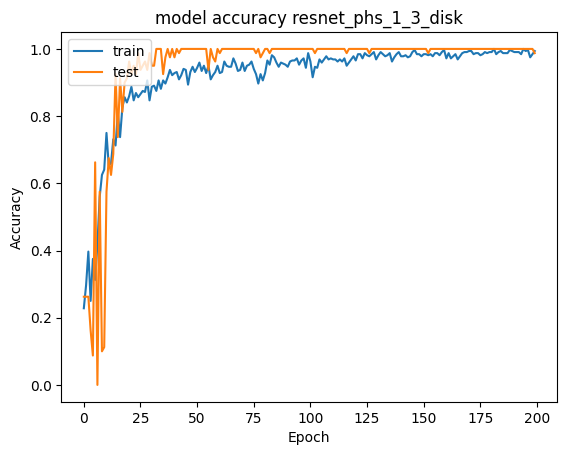

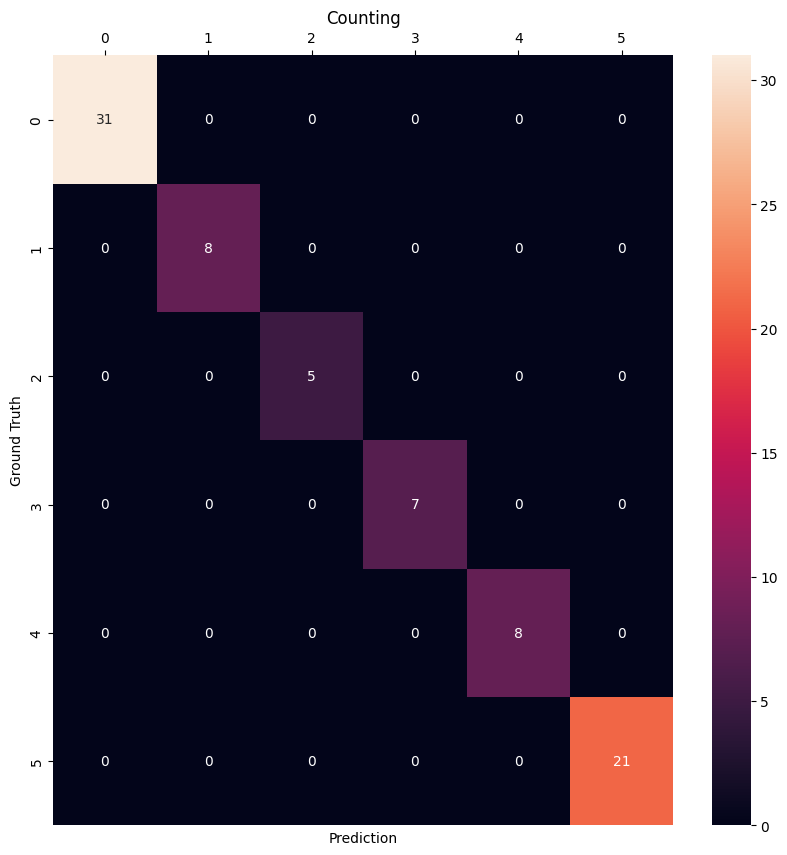

In [29]:
# non_norm_model = non_norm(len(range_fft_dict))
# base model
# model = basemodel(len(range_fft_dict))

# Resnet
filter_in_list = 1
filter_out_list = [32, 32, 64, 64]
kernel_size = (1,3)
# model = build_resnet(filter_in_list = filter_in_list, filter_out_list = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
model = Resnet2D(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=Y_train.shape[1])
# model = Resnet(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=Y_train.shape[1])
history = train_2D(model = model, X = X_train, Y = Y_train, test_X = X_test, test_Y = Y_test, cp_path = 'resnet_phs_1_3_disk', Epoch=200)